Neuromorphic engineering I

## Lab 5: Static Circuits: Transconductance Amplifier


**Reminder: Did you `git pull` the exercises before starting this notebook?**

Team member 1:

Team member 2: 

Date: 

-------------------------------------------------------------------------------------------------------------------

### Lab objectives

The objectives of this lab are to understand and characterize one of the most important circuit in analog IC design.

The experimental objectives are as follows:
1. To characterize simple 5-transistor (**5T**) N- and P-type differential transconductance amplifiers (**pta** and **PTA**) and understand its operation in terms of the behavior of the differential pair and the current mirror. Specifically, to understand the dependence of the output current on the differential input voltages.
2. To characterize single-stage 2-transistor “common-source” amplifier gain, and how it arises from transconductance and output impedance.
3. To compare the 5-T transamps pta and PTA with a wide-output-range transamp (**WRT**).

# 1 Prelab

## 1.1 Transconductance amplifier

### Ideal behavior

* <font color=#108ee9>What is the transamp transconductance </font> $g_m = \dfrac{\mathrm{d} I_{out}}{\mathrm{d} V_{in}}$, where
  $V_{in} \equiv V_1 - V_2$, in sub-threshold? 


* <font color=#108ee9>How does it change if
  the circuit is operated super-threshold?</font>

* <font color=#108ee9>Quantitatively, what is the relationship between transconductance, output
  resistance $r_o$, and voltage gain $A$ of a transconductance amplifier?</font>


### Transamp nonidealities

Consider the simple 5-T (*five transistor*) differential transconductance amplifier which is built from a
differential pair and a current mirror. The output current should be equal to the the
difference of the two differential pair currents, i. e. $I_{out} = I_1 - I_2$. 
* <font color=#108ee9>Is this statement
true? Justify your answer by stating your assumptions about transistor saturation and
drain conductance.</font>

Now consider the transconductance amplifier with the output open-circuited
  (i.e. no current flows into or out of the output node). Say $V_2$ is fixed
  at some voltage in the middle of the rails, e.g., $\frac{Vdd}{2}$. 
* <font color=#108ee9>Explain what happens to the
  output voltage as $V_1$ is swept from below $V_2$ to
  above $V_2$ for a subthreshold bias. Discuss the current through the
  differential pair transistors and the current mirror, and the voltage on
  the internal node common to the differential pair transistors.  **Try to keep
  the discussion concise.**</font>


## 1.2 Wide-Range Transamp

* <font color=#108ee9>Draw the schematic of a wide-range transconductance amplifier and explain why it
does not have the simple 5-transistor transamp restriction on allowable output voltage.</font>
You can either draw the schematic directly on the Jupyter notebook using the _schemdraw_ , or sketch it with pen and paper and paste a picture in a Markdown cell.

# 2 Setup

You may want to install all the necessary requirements (python libraries)

In [ ]:
import sys
!{sys.executable} -m pip install -r requirements.txt --upgrade # note upgrade to update jupyter-save-load-vars
# you may need to restart kernel if new libraries got installed.

## 2.1 Connect the device

Import necessary python libraries. The cell below may be collapsed.

In [ ]:
import time # for time.sleep(seconds)
import numpy as np # numpy for arrays etc
from scipy import stats # for stats.linregress
import matplotlib
import matplotlib.pyplot as plt # for plotting
import matplotlib
plt.rcParams.update({'font.size': 12}) # make the detault font size larger for your readers
matplotlib.rcParams['pdf.fonttype'] = 42 # save fonts as type that are not outlined in illustrator or other drawing programs
from engineering_notation import EngNumber as ef # format numbers in engineering format quickly, e.g. ef(2e-9)='2n' https://pypi.org/project/engineering-notation/
from pathlib import Path # used for saving data

datapath = Path('data/lab5') # make a data folder to save your data called data/lab5
datapath.mkdir(parents=True, exist_ok=True)
from jupyter_save_load_vars import savevars, loadvars
from tqdm import tqdm

import pyplane # for type hinting of biasgen constants
from ne1 import Coach # import Coach() class
import logging
p=Coach(logging_level=logging.INFO) # NOTE change to INFO to reduce clutter - create a Coach object called p; you will use it to talk to class chip, change to logging.DEBUG for troubleshooting
# p.open()

# below lines are notebook magic for debugging, you can uncomment them when debugging the Coach() class
# %load_ext autoreload
# %autoreload explicit
# %aimport ne1


In [ ]:
p.open() # test it
p.close()

# 3 N-Type 5T Transamp (**NTA**)

There are 3 sets of experiments, using the [NTA](#3-n-type-5t-transamp-nta), the [PTA](#4-p-type-5t-transamp), and the [WTA](#5-wide-range-transamp).

We will start with the NTA.

## 3.0 Schematic and pin map

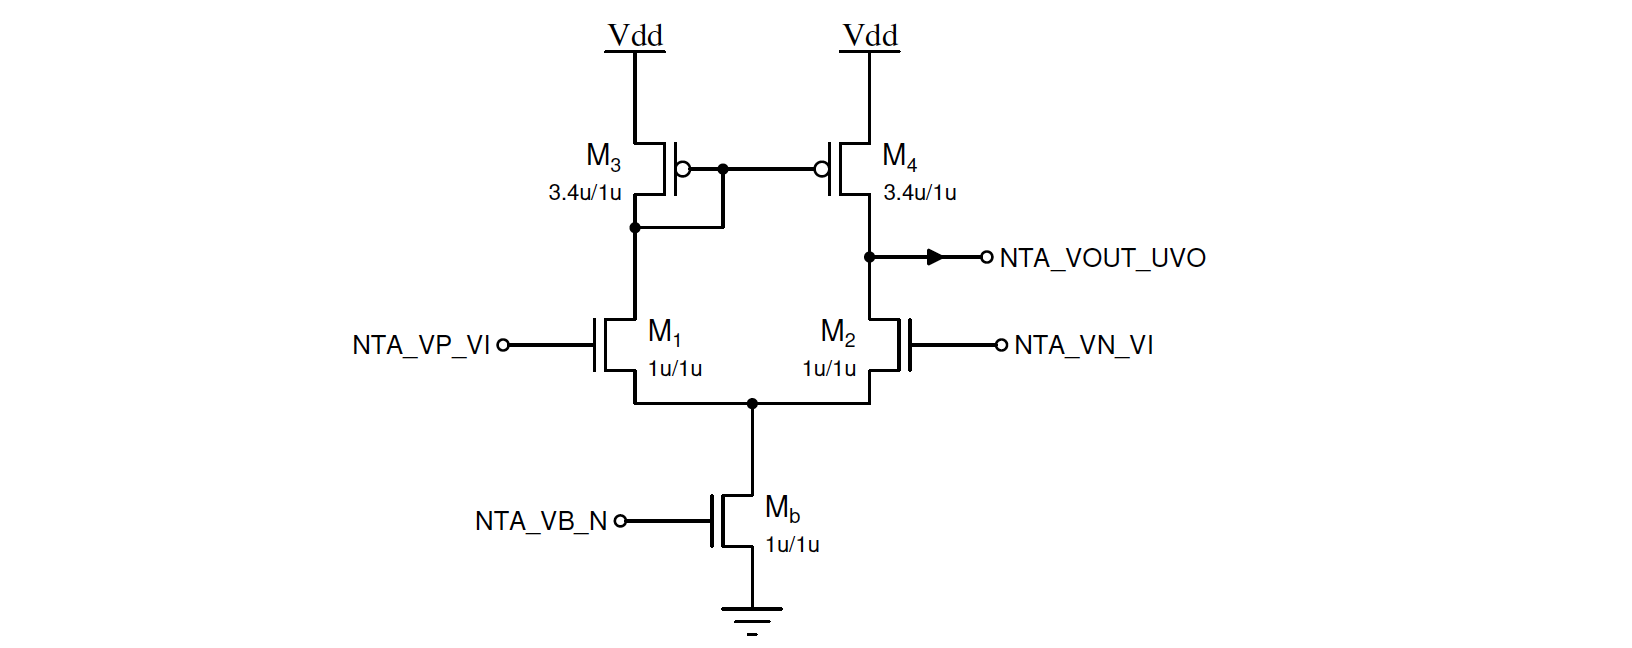

**$V_1$ = $V_p$ = NTA_VP_VI = AIN3**

**$V_2$ = $V_n$ = NTA_VN_VI = AIN4**

**$V_{out}$ = NTA_VOUT_UVO = ADC[13]**

**$I_{out}$ = $I_+ - I_-$ = NTA_IOUT_UO - NTA_IOUT_UBO = C2F[11] - C2F[12]**;   **Note that $I_+$ and $I_-$ is not $I_1$ and $I_2$.**

**Note: There are three (nominally) identical NTA circuits with the same bias and input voltages, one with the output open-circuited and routed out at NTA_VOUT_UVO, the other two with $V_{out}$ fixed to 1V but $I_{out}$ routed out through N- and P- type current mirror at NTA_IOUT_UO and NTA_IOUT_UBO.**  The sketch below shows how the currents and voltages are instrumented.

##### Three transamp scheme
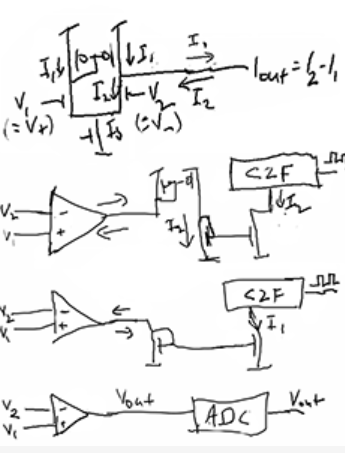

We are interested in both a voltage and current output from the N- and P-type 5T
transamps. However, there are two difficulties here: first, reading both voltage and
current is difficult to do without one measurement affecting the other, and second, the
current output of the transamps is signed.

The solution we chose is to have three duplicate instances of each transamp, with
inputs and biases tied together, the output voltage read out of one instance and the
two currents read out of the other two instances by mirroring only one sign of each current.
The measurements of each current are then subtracted as a model of the differential output current.

While it is expected that this method is susceptible to mismatch across the three
instances,  mismatch analysis shows that measurements of device transconductance
based on them yield reasonable results.

See [Chip architecture report](https://drive.google.com/file/d/1ljX2ACBuOxAENr4ZQkguyslIfM6LT5ks/view?usp=sharing), Section 7.1.

<font color=#FF0000>NOTE that this way of measuring I1 (the positive output current) holds Vout near ground. It means that only low common mode voltages will produce reasonable output.</font> See the prelab question in the [transamp section of prelab](#11-transconductance-amplifier), in particular [transamp nonidealities](#transamp-nonidealities).

## 3.1 Chip configuration for measuring NTA

Let's do a first basic test of fixing $V_2$ and sweeping $V_1$ around it and recording the open-loop $V_{\rm out}$. It should act like a voltage comparator with relative low gain.
When $V_1$ is less than $V_2$, $V_{\rm out}$ should be low, and then it should go to Vdd when $V_1$ gets larger than $V_2$.

Let's try it.

You should be aware that voltages drive the CoACH circuits from four [10-bit DAC53608](https://drive.google.com/file/d/16buxA_tguNB_oKbK_hF1rC479WKIDtUs/view?usp=sharing) Digital to Analog Converters. This 10-bit converter has reference voltage of 1.8V coming from the PCSI varient of the [TPS770](https://drive.google.com/file/d/1WS8372R_JP9R8kzcLx_q4lKx_MjaAlYX/view?usp=drive_link) linear regulator. **Therefore, the smallest output voltage step is 1800/1024=1.76mV.**


In [ ]:
# configure N type TransAmp
p=Coach()
p.setup_nta()
# set the Ib NTA bias current. You can use different BiasGenMasterCurrent from the enums in
# https://code.ini.uzh.ch/CoACH/CoACH_Teensy_interface/-/blob/master/src/pc/coach.h
ib=p.set_nta_ib(pyplane.Coach.BiasGenMasterCurrent.I3_8nA,5)
vdd=1.8
v2=vdd-.5 # the V2 (minus) input is fixed
p.set_nta_v2(v2) # set it fixed outside loop

v1=np.arange(0,vdd,8* 1.8/1024) # you can use arange if you want to set the step size instead of # steps. here we try the smallest possible step size
vout=[]
vin=[]
from tqdm import tqdm # great lib for progress bars
for v in tqdm(v1): # see how tqdm wraps the iterable np.array?
    vin.append(p.set_nta_v1(v))  # save the actual quantized v1
    time.sleep(.05) # let output settle
    vout.append(vo:=p.measure_nta_vout()) # measure output (vo:= assigns in loop in case you want to print them)
vout=np.array(vout) # make np.array for efficiency
vin=np.array(vin)


In [ ]:
# plt.plot(vin,vout,'x', vin, vin, 'k-', [v1,v1],[0,vdd],':',v1,vmin,'r')
plt.plot(vin,vout,'x', vin, vin, 'k-', [v2,v2],[0,vdd])
plt.legend(['Vout','V1','V2'])
plt.xlabel('$V_1$ (V)')
plt.ylabel('$V_{out}$ (V)')
plt.title(f'Fig. 3.1: N-type 5-T OTA with $V_2$ at Vdd/2, $I_b$={ef(ib)}A')
plt.show()

Did it work?  You should have gotten something like this:

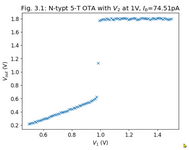

If not, then check your bias settings. Maybe you are not giving time for the output to settle. Even though the NTA output is buffered by a unity-gain on-chip voltage buffer, it still needs to drive its capacitive input. You can also play with the $I_b$ bias current.

<!-- We will come back to the reason for this oddly shaped output voltage later when we consider the "V min" problem. -->


* <font color=#108ee9>**Comment on these results**. Do you observe an offset voltage? What can it come from?</font>

## 3.2 Calibration of C2F channels

Here you need to calibrate NTA_IOUT_UO (Iplus) and NTA_IOUT_UBO (Iminus) in the same way as the last lab so that you can quantify the $I_1$ and $I_2$ currents relative to $I_b$.

* <font color=#108ee9>Sweeep </font> $I_b$ and inside the loop, set voltages such that $V_1\gg V_2$ so that all the current goes to $I_1$ side of NTA and then to the $I_2$ side. 
* <font color=#000000>Capture the C2F frequencies for each </font> $I_b$.

In [ ]:
p.setup_nta()
c2f_fine_currents = np.arange(0,85,4) # bias current sweep range, fine value

c2f_i1_freqs = []  # what you get is frequency
c2f_i2_freqs = []  # what you get is frequency
c2f_ibs=[]

# we will slap these during sweep to get both Iplus and Iminus c2f in one sweep
vplus=.8
vminus=0.2 

for n in tqdm(range(len(c2f_fine_currents))):
    ib=p.set_nta_ib(pyplane.Coach.BiasGenMasterCurrent.I30nA,int(c2f_fine_currents[n]))
    c2f_ibs.append(ib)
    
    p.set_nta_v1(vminus) # steer to iminus
    p.set_nta_v2(vplus)
    freqs = p.measure_c2f_freqs(0.1)  # read c2f values
    c2f_i2_freqs.append(freqs[p.NTA_I2_C2F_CHANNEL])

    p.set_nta_v1(vplus) # steer to iplus
    p.set_nta_v2(vminus) 
    freqs = p.measure_c2f_freqs(0.1)  # read c2f values
    c2f_i1_freqs.append(freqs[p.NTA_I1_C2F_CHANNEL])

c2f_ibs=np.array(c2f_ibs)
c2f_i1_freqs=np.array(c2f_i1_freqs)
c2f_i2_freqs=np.array(c2f_i2_freqs)

In [ ]:
plt.plot(c2f_ibs,c2f_i1_freqs, 'o', c2f_ibs,c2f_i2_freqs, 'x')
plt.xlabel('$I_b$ (A)')
plt.ylabel('C2F freq (Hz)')
plt.title(f'Fig. 3.2.1: NTA C2F calibration')
plt.legend(['I1','I2'])
plt.show()

You should see something like this only with two curves, one for each C2F attached to the NTA copy with I1 and I2 outputs: Check that when Ib is zero, the frequency is zero too, or close to it!!

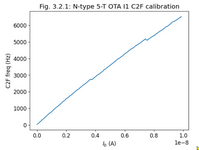

You may see a **huge** mismatch between the two channels. We suspect it is caused by poor mirroring of the NTA I2 output to the C2F circuit. 

We used $V_1$ and $V_2$ so that $V_1 \gg V_2$. For these values, the corresponding currents becomes $I_1 \approx I_b$ and $I_2 \approx 0$. The measured data can then determine the mapping between $I_1 \approx I_b$ and the C2F measurements of $I_1$ for the transconductance amplifier.

* <font color=#108ee9>Fit the data to compute the calibration polynomials `i1_cal` and `i2_cal` for the function `f2i`, which computes the functions $I(f)$.</font> (Hint: use higher order polynomial to increase accuracy.)

In [ ]:
# fit polynomial to C2F vs Ib data
# NOTE here we polyfit(y=freq,x=current), not the usual polyfit(x,y), because we want to use the fit to compute x from y, i.e., compute current from frequency
order=3
i1_cal = np.polyfit(c2f_i1_freqs,c2f_ibs,order) # returns a vector of polynomial factors starting with highest order
i2_cal = np.polyfit(c2f_i2_freqs,c2f_ibs,order) # returns a vector of polynomial factors starting with highest order

def f2i(freq,fit): #define a function to use for converting freq to current given a polyfit
    """ Computes the currents corresponding to C2F frequencies given a polynomial fit
    :param freq: the array of frequencies in Hz
    :param fit: the polynomial fit from np.polyfit
    :return: the array of currents
    """
    freq_arr=np.array(freq)
    
    i = np.polyval(fit,freq) # fit[0]+fit[1]*freq_arr+fit[2]*freq_arr**2
    return i

plt.plot(c2f_ibs,c2f_i1_freqs, 'x', c2f_ibs,c2f_i2_freqs,'x') # plot data
# plot fits, note how we plot the fit as x and the frequency as y
plt.plot(  f2i(c2f_i1_freqs,i1_cal), c2f_i1_freqs, '-')
plt.plot(  f2i(c2f_i2_freqs,i2_cal)  , c2f_i2_freqs, '-') 
plt.xlabel('$I_b$ (A)')
plt.ylabel('C2F freq (Hz)')
plt.title(f'Fig. 3.2.1: NTA C2F calibration with fits')
plt.legend(['I1','I2','I1 fit','I2 fit'])
plt.show()


Does it look ok? You should get something like this:

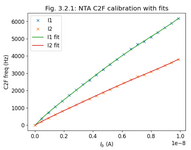

## 3.3 NTA Output current vs. input voltage (transconductance)
Now we are ready to measure the transconductance.  We can do it pretty much like we did the diff pair last week. For your convenience we copied over some of this code and adapted it for this exercise.

In [ ]:
p.close()
p.open()

* <font color=#108ee9>Sweep differential voltage $V_{\rm diff}$ and measure $I_{\rm out}=I_1-I_2$.</font>

In [ ]:
Vcm_nta = 0.9 # the common-mode voltage
v_range=np.arange(-.3,.3,5e-3) # range of differential inputs
V1_Vcm_nta = Vcm_nta+v_range/2 # V1 sweep range
V2_Vcm_nta = Vcm_nta-v_range/2 # V2 sweep range

V1_Vcm_nta_set = []
V2_Vcm_nta_set = []
i1_nta = []
i2_nta = [] # we will just store the computed currents from freq using our calibrations

p.setup_nta()
ib_nta=p.set_nta_ib(pyplane.Coach.BiasGenMasterCurrent.I30nA,100)

for v1,v2 in tqdm(zip(V1_Vcm_nta,V2_Vcm_nta)):
  
    # set V1 and V2 and record the quantized DAC values as our inputs
    V1_Vcm_nta_set.append(p.set_nta_v1(v1)) # V1
    V2_Vcm_nta_set.append(p.set_nta_v2(v2)) # V2 
    time.sleep(0.01) # settle time
    # read c2f values 
    bab_c2f_freqs = p.measure_c2f_freqs(0.1) # this call to low level pyplane function returns an array of event count values
    i1_nta.append(f2i(bab_c2f_freqs[p.NTA_I1_C2F_CHANNEL],i1_cal))
    i2_nta.append(f2i(bab_c2f_freqs[p.NTA_I2_C2F_CHANNEL],i2_cal))
i1_nta=np.array(i1_nta)
i2_nta=np.array(i2_nta)

In [ ]:
# compute vdiff and iout=i1-i2
vdiff_nta = V1_Vcm_nta - V2_Vcm_nta
iout_nta=i1_nta-i2_nta

# plot with x-axis and y-axes in middle as appropriate for this data
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plt.plot(vdiff_nta,i1_nta, 'b+',
         vdiff_nta,i2_nta,'r*',
         vdiff_nta,iout_nta,'go')

#spine placement data centered
# https://stackoverflow.com/questions/31556446/how-to-draw-axis-in-the-middle-of-the-figure
ax.spines['left'].set_position(('data', 0.0))
ax.spines['bottom'].set_position(('data', 0.0))
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

plt.xlabel('$V_1-V_2$ [V]')
plt.ylabel('Current (A)')
plt.legend(['$I_1$','$I_2$','$I_{out}$ (computed)'],prop={'size': 14})
plt.title(f'Fig. 3.3: NTA transconductance with $I_b$={ef(ib_nta)}A at Vcm={ef(Vcm_nta)}V.')
plt.grid()
plt.show()


You should have gotten something like this:  You can see that the measurement of I2 is definitely not ideal. The current mirror input to the C2F circuit seems to cut off the small currents. We do not know the reason for this behavior.

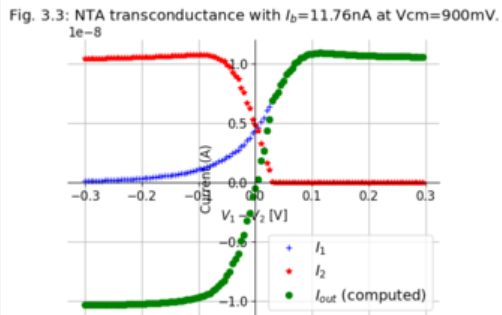



* Save raw data

In [ ]:
# if the data looks nice, save it!
savevars(datapath/'nta')

In [ ]:
# maybe you need to load your saved data?
loadvars(datapath/'nta')


* <font color=#108ee9>Add a plot of the theoretical Iout using the bias current that you set and a kappa value that you determine by playing with it until it fits as well as possible.</font>


In [ ]:
k=.3
ut=25e-3
iout_theory_nta=ib_nta*np.tanh((k*vdiff_nta)/(2*ut))

# plot with x-axis and y-axes in middle as appropriate for this data
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plt.plot(vdiff_nta,iout_nta,'go', vdiff_nta,iout_theory_nta,'g-')

#spine placement data centered
# https://stackoverflow.com/questions/31556446/how-to-draw-axis-in-the-middle-of-the-figure
ax.spines['left'].set_position(('data', 0.0))
ax.spines['bottom'].set_position(('data', 0.0))
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

plt.xlabel('$V_1-V_2$ [V]')
plt.ylabel('Current (A)')
plt.legend(['$I_{out}$ (computed)','$I_{out}$ theory'],prop={'size': 14})
plt.title(f'Fig. 3.4: NTA transconductance with theory with $I_b$={ef(ib_nta)}A and kappa={k}.')
plt.grid()
plt.show()


*<font color=#108ee9> Compute transconductance by plotting </font> $g_m=dI/dV$.

In [ ]:
# you can try using np.gradient
gm_nta=np.gradient(iout_nta,vdiff_nta)
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

plt.plot(vdiff_nta,gm_nta)

#spine placement data centered
# https://stackoverflow.com/questions/31556446/how-to-draw-axis-in-the-middle-of-the-figure
ax.spines['left'].set_position(('data', 0.0))
ax.spines['bottom'].set_position(('data', 0.0))
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

plt.xlabel('$V_1-V_2$ [V]')
plt.ylabel('$g_m$ (A/V)')
plt.title(f'Fig. 3.5: NTA transconductance $I_b$={ef(ib_nta)}A.')
plt.grid()
plt.show()

* <font color=#108ee9>Explain any asymmetries in the amplifier’s I-V curve and the offset voltage in terms of mismatch between devices in the mirror and differential pair.</font>


* <font color=#108ee9>Do you think we can distinguish the effects of mismatch in the current mirror and in the differential pair?</font>

The main point here is to recognize that there will be non-idealities, to understand where they arise.

## 3.5 Different NTA bias currents (**optional**)

* <font color=#800080>Repeat 3.4.1 with another two bias currents, one smaller and one larger, and compare the three curves. </font> Try to make the largest $I_b$ be above threshold, so you can observe how the linear region widens.

#### Here is a function `capture_nta` that does the heavy lifting

In [ ]:
def capture_nta(p, coarse_current, fine_value,v_cm):
    """captures NTA data

    :param p: the Coach object
    :param coarse_current: bias current Ib pyplane.Coach.BiasGenMasterCurrent.XXX value
    :param fine_value: bias current fine value, 0-255 int
    :param v_cm: the common mode voltage
        NOTE: very important, since the I1 current is a positive output current, it is mirrored into the C2F with an n-type mirror that holds the output of 
        the transamp a diode drop from ground. Therefore the transamp will only work with low V_cm.
    :return: vdiff,iout,ib
    """

    if v_cm>=vdd/2:
        print(f' ****** DANGER Will Robinson - the common mode voltage {v_cm}V is too low!!!!!')
    # first let's calibrate the C2F circuits for this range of current
    p.setup_nta()
    # bias current sweep range - we only need to calibrate up to this fine value which is the maximum current we will see on NTA output
    c2f_fine_currents = np.arange(0,fine_value,2) 

    c2f_i1_freqs = []  # what you get is frequency
    c2f_i2_freqs = []  # what you get is frequency
    c2f_ibs=[]

    # we will swap these during sweep to get both Iplus and Iminus c2f in one sweep
    vplus=.8
    vminus=0.2 

    print(f'**** calibrating {coarse_current}')
    for n in tqdm(range(len(c2f_fine_currents))):
        ib=p.set_nta_ib(coarse_current,int(c2f_fine_currents[n]))
        c2f_ibs.append(ib)
        
        p.set_nta_v1(vminus) # steer to iminus
        p.set_nta_v2(vplus)
        freqs = p.measure_c2f_freqs(0.1)  # read c2f values
        c2f_i2_freqs.append(freqs[p.NTA_I2_C2F_CHANNEL])

        p.set_nta_v1(vplus) # steer to iplus
        p.set_nta_v2(vminus) 
        freqs = p.measure_c2f_freqs(0.1)  # read c2f values
        c2f_i1_freqs.append(freqs[p.NTA_I1_C2F_CHANNEL])

    c2f_ibs=np.array(c2f_ibs)
    c2f_i1_freqs=np.array(c2f_i1_freqs)
    c2f_i2_freqs=np.array(c2f_i2_freqs)

    order=3
    i1_cal = np.polyfit(c2f_i1_freqs,c2f_ibs,order) # returns a vector of polynomial factors starting with highest order
    i2_cal = np.polyfit(c2f_i2_freqs,c2f_ibs,order) # returns a vector of polynomial factors starting with highest order

    def f2i(freq,fit): #define a function to use for converting freq to current given a polyfit
        """ Computes the currents corresponding to C2F frequencies given a polynomial fit
        :param freq: the array of frequencies in Hz
        :param fit: the polynomial fit from np.polyfit
        :return: the array of currents
        """
        
        currents = np.polyval(fit,freq) 
        return currents

    plt.rcParams.update({'font.size': 8}) 
    # fig=plt.figure()
    fig=plt.figure(figsize=(9,3), dpi= 100, facecolor='w', edgecolor='k')
    plt.subplot(1,3,1)
    plt.plot(c2f_ibs,c2f_i1_freqs, 'rx', c2f_ibs,c2f_i2_freqs,'gx') # plot data
    # plot fits, note how we plot the fit as x and the frequency as y
    plt.plot(  f2i(c2f_i1_freqs,i1_cal), c2f_i1_freqs, 'r-')
    plt.plot(  f2i(c2f_i2_freqs,i2_cal)  , c2f_i2_freqs, 'g-') 
    plt.xlabel('$I_b$ (A)')
    plt.ylabel('C2F freq (Hz)')
    plt.legend(['I1','I2','I1 fit','I2 fit'])

    Vcm_nta = v_cm # the common-mode voltage
    v_range=np.arange(-.3,.3,8*1.8/1024) # range of differential inputs
    V1_Vcm_nta = Vcm_nta+v_range/2 # V1 sweep range
    # V1_Vcm_nta = Vcm_nta * np.ones_like(v_range)
    V2_Vcm_nta = Vcm_nta-v_range/2 # V2 sweep range
    # V2_Vcm_nta = Vcm_nta * np.ones_like(v_range)

    V1_Vcm_nta_set = []
    V2_Vcm_nta_set = []
    i1_nta = []
    i2_nta = [] # we will just store the computed currents from freq using our calibrations
    f1s=[]
    f2s=[] # save freqs
    ib=p.set_nta_ib(coarse_current,fine_value)
    print(f'capturing transconductance for ib={ef(ib)}A V_cm={ef(v_cm)}V')
    for v1,v2 in tqdm(zip(V1_Vcm_nta,V2_Vcm_nta)):
        # set V1 and V2 and record the quantized DAC values as our inputs
        V2_Vcm_nta_set.append(p.set_nta_v2(v2)) # V2 
        V1_Vcm_nta_set.append(p.set_nta_v1(v1)) # V1
        time.sleep(0.3) # settle time
        fs = p.measure_c2f_freqs(0.1) # this call to low level pyplane function returns an array of event count values
        f1=fs[p.NTA_I1_C2F_CHANNEL]
        f2=fs[p.NTA_I2_C2F_CHANNEL]
        i1_nta.append(f2i(f1,i1_cal))
        i2_nta.append(f2i(f2,i2_cal))
        f1s.append(f1)
        f2s.append(f2)
    i1_nta=np.array(i1_nta)
    i2_nta=np.array(i2_nta)
    f1s=np.array(f1s)
    f2s=np.array(f2s)
    vdiff=np.array(V1_Vcm_nta_set)-np.array(V2_Vcm_nta_set)
    iout=i1_nta-i2_nta
    plt.subplot(1,3,2)
    plt.plot(vdiff,f1s,vdiff,f2s)
    plt.legend(['f1','f2'])
    plt.xlabel('V1-V2 (V)')
    plt.ylabel('C2F freq (Hz)')
    plt.subplot(1,3,3)
    plt.plot(vdiff,i1_nta,vdiff,i2_nta)
    plt.legend(['I1','I2'])
    plt.xlabel('V1-V2 (V)')
    plt.ylabel('Current (A)')

    fig.suptitle(f'NTA C2F calib and g_m for {coarse_current} V_cm={v_cm} Ib={ef(ib)}A')

    plt.show()
    return vdiff,iout,ib


* Now actually capture the data for different Ib spanning a large range

In [ ]:
# NOTE Tobi played with many parameters here and these are the best he could get
coarse_values=[pyplane.Coach.BiasGenMasterCurrent.I460pA,pyplane.Coach.BiasGenMasterCurrent.I3_8nA,pyplane.Coach.BiasGenMasterCurrent.I240nA]
fine_values=[35,63,60] 
vdd=1.8
v_cm=.5

iouts=[]
iouts_norm=[]
leg=[]
p=Coach()
try:
    p.open()
    for cb,fb in zip(coarse_values,fine_values):
        vd,iout,ib=capture_nta(p, cb,fb,v_cm)
        iouts.append(iout)
        iouts_norm.append(iout/np.max(iout))
        leg.append(f'Ib={ef(ib)}')
finally:
    p.close()
iouts=np.vstack(iouts)
iouts_norm=np.vstack(iouts_norm)


* Plot all the data together, with output current normalized

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plt.plot(vd,np.transpose(iouts_norm))
plt.legend(leg)
plt.xlabel('V1-V2 (V)')
plt.ylabel('Normalized Iout')
plt.title('Fig 3.5 5T-OTA Iout vs V1-V2 for various Ib (normalized to max value)')
#spine placement data centered
# https://stackoverflow.com/questions/31556446/how-to-draw-axis-in-the-middle-of-the-figure
ax.spines['left'].set_position(('data', 0.0))
ax.spines['bottom'].set_position(('data', 0.0))
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

* <font color=#108ee9>Discuss your results</font>

## 3.5 Different NTA common mode voltages (**optional**)

<font color=#FF0000>Since the output current measurement is limited to only small V_cm due to the current-mirror readout to the I1 CTF, this experiment is probably not possible. We leave it here in case someone wants to try to get it to work.</font>

* Repeat 3.4.1 with another two common mode voltages, one close to ground and the other close to Vdd, and compare the three curves.

* What do you observe when the common mode voltage $V_{cm}$ is too small (e.g. 0.2V or 0.3V)?
Does it have a sigmoid shape? If not, try to explain why.


# 4 P-Type 5T Transamp

## 4.0 Schematic and pin map

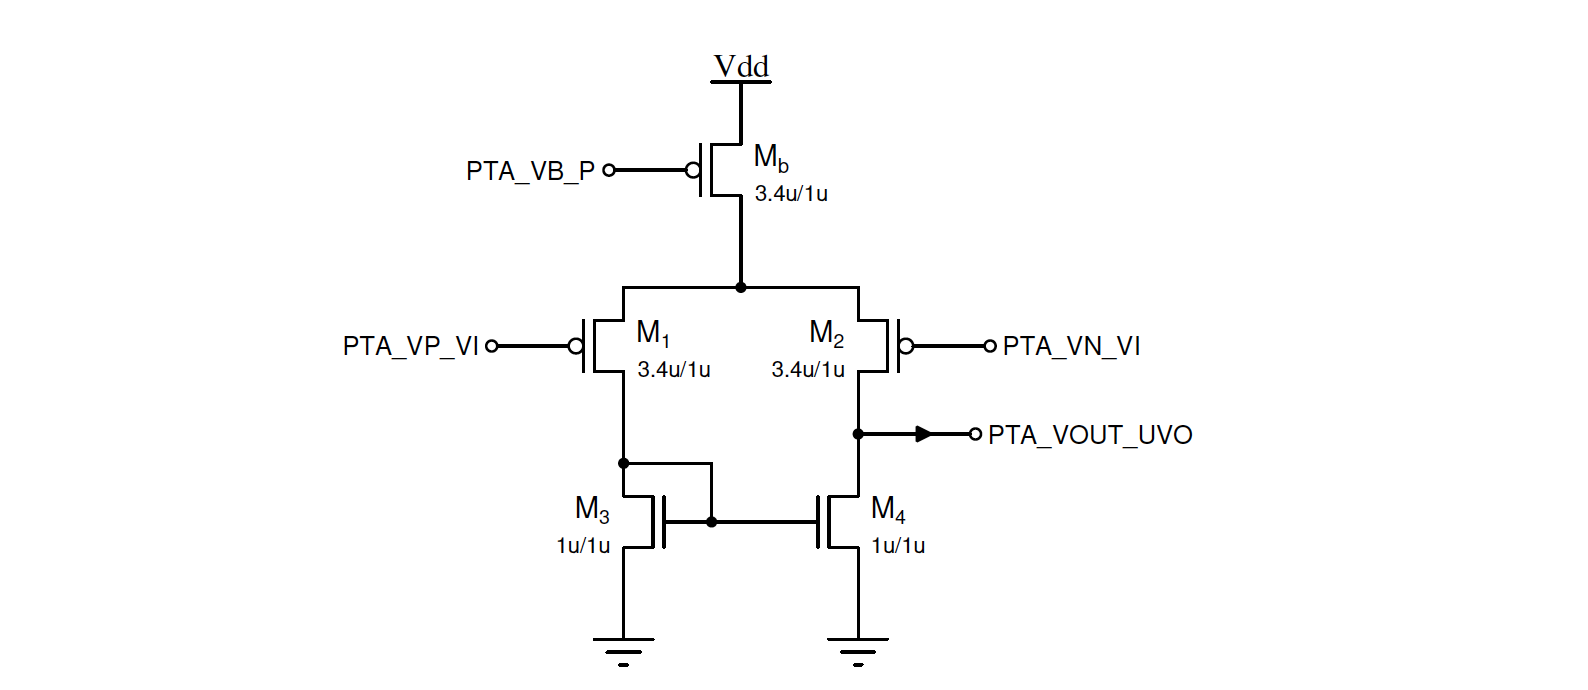

**$V_1$ = $V_p$ = PTA_VP_VI = AIN7**

**$V_2$ = $V_n$ = PTA_VN_VI = AIN8**

**$V_{out}$ = PTA_VOUT_UVO = ADC[12]**

**$I_{out}$ = $I_+ - I_-$ = PTA_IOUT_UO - PTA_IOUT_UBO = C2F[13] - C2F[14]**

**Note: There are three identical PTA circuits with the same bias and input voltages, one with the output open-circuited and routed out at PTA_VOUT_UVO, the other two with $V_{out}$ fixed to 1V but $I_{out}$ routed out through N- and P- type current mirror at PTA_IOUT_UO and PTA_IOUT_UBO.**

## 4.2 PTA measurements and analysis
* <font color=#108ee9>Repeat measurements you did for the NTA using the PTA. You should be able to copy code from above and easily adapt it.</font>

You only need to compare PTA with NTA for a single $I_b$ and $V_{\rm cm}$.

You can use the `set_pta_XXX` and `measure_pta_XXX` methods.

### For your convenience we already wrote code PTA code for you

This save you a lot of nasty replacements

In [ ]:
# NOTE  take PTA calibration 
p=Coach()
p.setup_pta()
c2f_fine_currents = np.arange(0,85,4) # bias current sweep range, fine value

c2f_i1_freqs = []  # what you get is frequency
c2f_i2_freqs = []  # what you get is frequency
c2f_ibs=[]

# we will slap these during sweep to get both Iplus and Iminus c2f in one sweep
vplus=.8
vminus=0.2 

for n in tqdm(range(len(c2f_fine_currents))):
    ib=p.set_pta_ib(pyplane.Coach.BiasGenMasterCurrent.I30nA,int(c2f_fine_currents[n]))
    c2f_ibs.append(ib)
    
    p.set_pta_v1(vminus) # steer to iminus
    p.set_pta_v2(vplus)
    freqs = p.measure_c2f_freqs(0.1)  # read c2f values
    c2f_i2_freqs.append(freqs[p.PTA_I2_C2F_CHANNEL])

    p.set_pta_v1(vplus) # steer to iplus
    p.set_pta_v2(vminus) 
    freqs = p.measure_c2f_freqs(0.1)  # read c2f values
    c2f_i1_freqs.append(freqs[p.PTA_I1_C2F_CHANNEL])

c2f_ibs=np.array(c2f_ibs)
c2f_i1_freqs=np.array(c2f_i1_freqs)
c2f_i2_freqs=np.array(c2f_i2_freqs)

# fit polynomial to C2F vs Ib data
# NOTE here we polyfit(y=freq,x=current), not the usual polyfit(x,y), because we want to use the fit to compute x from y, i.e., compute current from frequency
order=3
i1_cal = np.polyfit(c2f_i1_freqs,c2f_ibs,order) # returns a vector of polynomial factors starting with highest order
i2_cal = np.polyfit(c2f_i2_freqs,c2f_ibs,order) # returns a vector of polynomial factors starting with highest order

def f2i(freq,fit): #define a function to use for converting freq to current given a polyfit
    """ Computes the currents corresponding to C2F frequencies given a polynomial fit
    :param freq: the array of frequencies in Hz
    :param fit: the polynomial fit from np.polyfit
    :return: the array of currents
    """
    freq_arr=np.array(freq)
    
    i = np.polyval(fit,freq) # fit[0]+fit[1]*freq_arr+fit[2]*freq_arr**2
    return i

plt.plot(c2f_ibs,c2f_i1_freqs, 'x', c2f_ibs,c2f_i2_freqs,'x') # plot data
# plot fits, note how we plot the fit as x and the frequency as y
plt.plot(  f2i(c2f_i1_freqs,i1_cal), c2f_i1_freqs, '-')
plt.plot(  f2i(c2f_i2_freqs,i2_cal)  , c2f_i2_freqs, '-') 
plt.xlabel('$I_b$ (A)')
plt.ylabel('C2F freq (Hz)')
plt.title(f'Fig. 4.2.1: PTA C2F calibration with fits')
plt.legend(['I1','I2','I1 fit','I2 fit'])
plt.show()


In [ ]:

# NOTE take PTA data

Vcm_pta = 0.9 # the common-mode voltage
v_range=np.arange(-.3,.3,5e-3) # range of differential inputs
V1_Vcm_pta = Vcm_pta+v_range/2 # V1 sweep range
V2_Vcm_pta = Vcm_pta-v_range/2 # V2 sweep range

V1_Vcm_pta_set = []
V2_Vcm_pta_set = []
i1_pta = []
i2_pta = [] # we will just store the computed currents from freq using our calibrations

ib_pta=p.set_pta_ib(pyplane.Coach.BiasGenMasterCurrent.I30nA,100)

for v1,v2 in tqdm(zip(V1_Vcm_pta,V2_Vcm_pta)):
  
    # set V1 and V2 and record the quantized DAC values as our inputs
    V1_Vcm_pta_set.append(p.set_pta_v1(v1)) # V1
    V2_Vcm_pta_set.append(p.set_pta_v2(v2)) # V2 
    time.sleep(0.01) # settle time
    # read c2f values 
    bab_c2f_freqs = p.measure_c2f_freqs(0.1) # this call to low level pyplane function returns an array of event count values
    i1_pta.append(f2i(bab_c2f_freqs[p.PTA_I1_C2F_CHANNEL],i1_cal))
    i2_pta.append(f2i(bab_c2f_freqs[p.PTA_I2_C2F_CHANNEL],i2_cal))
i1_pta=np.array(i1_pta)
i2_pta=np.array(i2_pta)

# compute vdiff and iout=i1-i2
vdiff_pta = V1_Vcm_pta - V2_Vcm_pta
iout_pta=i1_pta-i2_pta

# plot with x-axis and y-axes in middle as appropriate for this data
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plt.plot(vdiff_pta,i1_pta, 'b+',
         vdiff_pta,i2_pta,'r*',
         vdiff_pta,iout_pta,'go')

#spine placement data centered
# https://stackoverflow.com/questions/31556446/how-to-draw-axis-in-the-middle-of-the-figure
ax.spines['left'].set_position(('data', 0.0))
ax.spines['bottom'].set_position(('data', 0.0))
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

plt.xlabel('$V_1-V_2$ [V]')
plt.ylabel('Current (A)')
plt.legend(['$I_1$','$I_2$','$I_{out}$ (computed)'],prop={'size': 14})
plt.title(f'Fig. 4.3: PTA transconductance with $I_b$={ef(ib_pta)}A at Vcm={ef(Vcm_pta)}V.')
plt.grid()
plt.show()


* <font color=#108ee9>Summarize your PTA results</font>

# 5 Wide-Range Transamp (**WRT**)

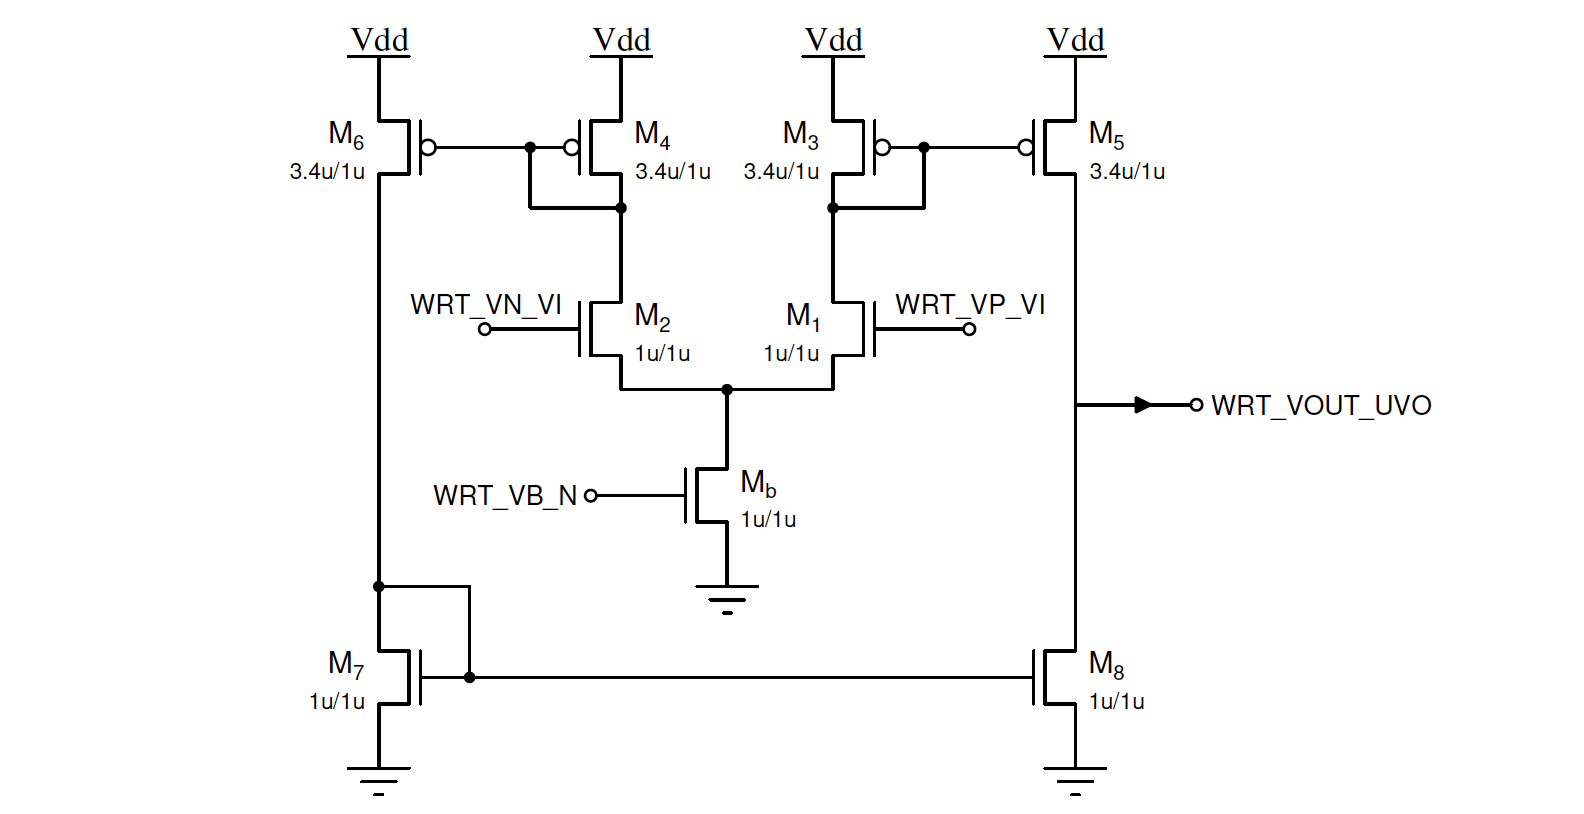

**$V_1$ = $V_p$ = WRT_VP_VI = AIN7**

**$V_2$ = $V_n$ = WRT_VN_VI = AIN8**

**$V_{out}$ = WRT_VOUT_UVO = ADC[11]**



## 5.1 WRT measurements

Note that for the WRT we can only measure the open-loop output voltage $V_{out}$.

This experiment compares the voltage gain $A$ of the WRT over different bias currents spanning sub- and super-threshold.

By inspecting the schematic, we can see that the output stage FETs are only 1um long, so we do not expect very high voltage gain. This sizing is a bit unfortunate to show the ability of the WRT to split the input and output stages and achieve high transconductance and high output resistance. But it is also fortunate because the limited resolution of the DAC output (1.8V/1024 levels) means that an amplifier with a gain of 1000 would already make a 1.8V step with one step of the DAC output.

Here are the steps:
1. Set a subthreshold bias current $I_b$ large enough that the high-gain circuit settles in reasonable time but still in subthreshold. Here we set multible Ib (see point 3).
2. Fix $V_2$ and sweep $V_1$ around it, and measure $V_{out}$ You need a very fine sweep because the voltage gain is on the order of hundreds or more. But the output stage FETs $M_5$ and $M_8$ are only 1um long, so the voltage gain is not so high.
3. Take multiple transfer functions with different Ib to see if it affects the transfer function.

* <font color=#108ee9>Take the voltage transfer function data yourself.</font> For your convenience we wrote the whole outer loop over different $I_b$ for you.


In [ ]:
p=Coach()
p.setup_wrt() # configure the WRT wide range transamp

# set the Ib WRT bias current. You can use different BiasGenMasterCurrent from the enums in
# https://code.ini.uzh.ch/CoACH/CoACH_Teensy_interface/-/blob/master/src/pc/coach.h I60pA, I460pA, I3_8nA, I30nA, I240nA
master_currents=[pyplane.Coach.BiasGenMasterCurrent.I60pA, 
    pyplane.Coach.BiasGenMasterCurrent.I30nA, pyplane.Coach.BiasGenMasterCurrent.I30nA, 
    pyplane.Coach.BiasGenMasterCurrent.I240nA, pyplane.Coach.BiasGenMasterCurrent.I240nA, pyplane.Coach.BiasGenMasterCurrent.I240nA] # specify the master currents
fine_currents=[50,30, 128, 64, 128, 255] # choose indiv currents for each master current to span larger range
v2=1 # the V2 (minus) input is fixed

wrt_ibs=[] # save the bias currents
vouts=[]
leg=[]
p.set_wrt_v2(v2) # set it fixed outside loop
v1=np.arange(.95,1.05,1.8/1024) # you can use arange if you want to set the step size instead of # steps
for master_current,fine_current in zip(master_currents,fine_currents):
    ib=p.set_wrt_ib(master_current,fine_current)
    print(f' collecting Vout vs V1 for Ib={ef(ib)}A ')
    wrt_ibs.append(ib)
    vout=[]
    vin=[]
    from tqdm import tqdm # great lib for progress bars
    for v in tqdm(v1): # see how tqdm wraps the iterable np.array?
        vin.append(p.set_wrt_v1(v))  # save the actual quantized v1
        time.sleep(.1) # let output settle
        vout.append(vo:=p.measure_wrt_vout()) # measure output (vo:= assigns in loop in case you want to print them)
    vout_wrt=np.array(vout) # make np.array for efficiency
    vin=np.array(vin)
    vouts.append(vout_wrt)
    # plot transfer function
    plt.plot(vin,vout,'x')
    plt.xlabel('$V_1$ (V)')
    plt.ylabel('$V_{out}$ (V)')
    leg.append(f'$I_b$={ef(ib)}A')
wrt_vouts=np.stack(vouts)
plt.legend(leg)
plt.title(f'Fig. 5.1: WRT Vout vs $V_1$ with $V_2$={v2}V')
wrt_vin=vin
plt.show()

In [ ]:
# if the data looks nice, save it!
savevars(datapath/'wrt', overwrite='yes')

In [ ]:
# plot transfer function
plt.plot(wrt_vin,np.transpose(wrt_vouts),'-x') # note we need to transpose the vout 2d array to match dimensions
plt.xlabel('$V_1$ (V)')
plt.ylabel('$V_{out}$ (V)')
plt.title(f'Fig. 5.1: N-type wide range OTA with $V_2$ at 1V')
leg=[]
for i in wrt_ibs:
    leg.append(f'$I_b$={ef(i)}A')
plt.legend(leg)
plt.show()

* <font color=#108ee9>From these sweeps, plot the voltage gain </font>  $A$ by computing the derivative $A=dV_{\rm out}/dV_{\rm in}$. 
 
It should peak somewhere.
  


In [ ]:
# compute and plot voltage gain
a_wrt=np.gradient(wrt_vouts,wrt_vin,axis=1) # https://numpy.org/doc/stable/reference/generated/numpy.gradient.html
plt.plot(wrt_vin,np.transpose(a_wrt),'-x')
plt.xlabel('$V_1$ (V)')
plt.ylabel('Gain $A$ (V/V)')
plt.title(f'Fig. 5.3: WRT gains')
leg=[]
for i in wrt_ibs:
    leg.append(f'$I_b$={ef(i)}A')
plt.legend(leg)
plt.show()

* <font color=#108ee9>Now, compute the maximum gain </font> $A_{\rm max}$ for each $I_b$ and plot $A_{\rm max}$ vs $I_b$.

In [ ]:
amax=np.max(a_wrt,axis=1) # we want to compute each max along the V1 axis (axis=1)
plt.semilogx(wrt_ibs,amax,'-x')
plt.xlabel('$I_b$ (A)')
plt.ylabel('Max. Gain $A_{max}$ (V/V)')
plt.title('Fig. 5.4: WRT gain vs. $I_b$')
plt.show()

* <font color=#108ee9>Can you see any change in voltage gain between sub- and super-threshold operation of the WTA? If so, can you explain it (quantitatively if possible)?</font> Recall the discussion of intrinsic transistor voltage gain and how it behaves in sub- and super-threshold operation of the FET.

  * Maybe you can improve the measurement with a bit more work to slow down the measurements at low current levels to allow the WRT output to settle, and with more $I_b$ values. You may even feel inspired to work out the theoretical gain in terms of $I_b$ and plot that with the measured open loop gain.

* Save your data?

In [ ]:
# if the data looks nice, save it!
savevars(datapath/'wrt',overwrite='yes')

# 6 Postlab

1. When we set the output voltage of the transconductance amplifier to a certain value between gnd and Vdd and measured its output current, we found that at some nonzero input voltage (the offset voltage) the output current was zero. <font color=#108ee9>Will we get a different input offset voltage if we change the output voltage? Explain why.</font>

2. <font color=#108ee9>What are the conditions </font> for keeping bias FET $M_b$ in saturation for the P-type transamp? Do they differ from the N-type transamp?

1. <font color=#108ee9>What are the advantages and disadvantages of the wide-output-range transconductance amplifier vs. a standard transconductance amplifier? </font> Consider layout area, output voltage swing, the and the gain A and transconductance $g_m$. <font color=#108ee9>Why is the wide-output-range transamp better suited for construction of a high-gain single-stage amplifier?</font> _Hint: think about the necessary symmetries between pairs of transistors._

## What we expect you to learn
Please see the [NE1 exam preparation guide](https://drive.google.com/file/d/1nOq3UbcEv_ik425VBYqcH9hAET7FyIeP/view?usp=drive_link)


# 8 Congratulations

Wish you joy when you look back on your works, beautiful plots and all your efforts!